# Do Not Delete!

In [ ]:
# DO NOT REMOVE THESE
%load_ext autoreload
%autoreload 2

In [ ]:
# DO NOT REMOVE This
%reload_ext autoreload

In [ ]:
## DO NOT REMOVE
## import local src module -
## src in this project will contain all your local code
## clean_data.py, model.py, visualize.py, custom.py

#import src.base with alias to avoid namespace clashes

from src import base as fis

In [ ]:
fis.test_base()

# Classifing Fraudulent Bank Transactions 

Adam Blomfield
Kelly Epley
Helen Levy-Myers

Our [dataset]('https://www.kaggle.com/mlg-ulb/creditcardfraud') contains 284,807 credit card transactions spanning a two day period from an unidentified bank in Europe. Each one is labeled as either legitimate or fraudulent. We developed a Random Forest machine learning model to catch the frauds.  


# Import Libraries

In [2]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas_profiling

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Data Preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# Resampling Methods
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Classifiers
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Model Tuning and Cross Validation
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV

# Model metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve


# Data Importing 


The original dataset contained 1081 duplicated rows, which we opted to drop. Also, after noticing that frauds are more concentrated at certain times of day, we decided to create bins for the time of day. For full details on our data cleaning and feature engineering process, see the notebook titled "data_cleaning."

In [3]:
# Cleaned DataFrame
clean_df = pd.read_csv('../data/processed/cleaned_dataframe.csv.gz', compression='gzip')
clean_df.shape

(283726, 33)

In [4]:
# Version 2: Cleaned DataFrame with the "Amount" column scaled for use in models that generate predictions
# on the basis of distance
clean_df_scaled = pd.read_csv('../data/processed/cleaned_dataframe_scaled.csv.gz', compression='gzip')
clean_df_scaled.shape

(283726, 33)

# Train-Test Split

In [5]:
X = clean_df.drop('Class', axis=1)
y = clean_df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=2)  

# stratify maintains the ratio of frauds to non frauds

In [6]:
X = clean_df_scaled.drop(['Class'], axis=1)
y = clean_df_scaled['Class']

X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(X, y, test_size=0.3, stratify=y, random_state=2)

# Modeling Function

We created a custom function to generate models so that we could quickly compare several classifiers.

This function performs the following tasks:
* Resamples the training data using SMOTE
* Fits the resampled data to a classifier
* Generates the predictions on the test data
* Prints accuracy, precision, recall, and F1 score
* Plots a confusion matrix of the predictions

We also created a similar function using undersampling and mixed undersampling and oversampling strategies, but oversampling consistently produced the best results.

In [12]:
def make_SMOTE_model(X_train, y_train, X_test, y_test, classifier):

# make pipeline 
    smote = SMOTE(random_state=1)

    pipe = make_pipeline(smote, classifier)
    model = pipe.fit(X_train, y_train)

# make predictions   
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

# print scores  
    print('Train Accuracy: ' + str(metrics.accuracy_score(y_train, train_predictions)))
    print('Train Precision: ' + str(metrics.precision_score(y_train, train_predictions)))
    print('Train Recall: ' + str(metrics.recall_score(y_train, train_predictions)))
    print('Train F1: ' + str(metrics.f1_score(y_train, train_predictions)))
    print('\n')
    print('Test Accuracy: ' + str(metrics.accuracy_score(y_test, test_predictions)))
    print('Test Precision: ' + str(metrics.precision_score(y_test, test_predictions)))
    print('Test Recall: ' + str(metrics.recall_score(y_test, test_predictions)))
    print('Test F1: ' + str(metrics.f1_score(y_test, test_predictions)))
    print('\n')
    
# print confusion matrix    
    cm = confusion_matrix(y_test, test_predictions)
    sns.heatmap(cm.T, square=True, annot=True, fmt = 'g', cmap='RdBu', cbar=False, xticklabels=['legitimate', 'fraud'], yticklabels=['legitimate', 'fraud'])
    plt.title('Confusion Matrix')
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    tn, fp, fn, tp = confusion_matrix(y_test, test_predictions).ravel()
    print("Confusion Matrix:",'\nTN:', tn, 'FP:', fp, 'FN:', fn, 'TP:', tp)



# Baseline Model and Model Metrics

Since the vast majority of bank transactions are not fraudulent, our dataset is highly imbalanced. 

Thus, we could get a model with a high accuracy score by simply predicting that all transactions are legitimate. 

In [8]:
num_of_transactions = len(clean_df)
num_of_frauds = len(clean_df[clean_df['Class']==0])
accuracy = round((num_of_frauds/num_of_transactions)*100, 6)
explanation = 'A model that treats all transactions as fraudulent has an accuracy score of'
print(explanation, '{}%'.format(accuracy))

A model that treats all transactions as fraudulent has an accuracy score of 99.83329%


With imbalanced data, an accuracy score isn't diagnostic because correct majority class predictions (non-frauds) are enough to produce a high score. A good model will catch as many frauds as possible while minimizing the number of transactions flagged as fraud that are actually legitimate.

If we want to know how well a model predicts the minority class (fraud), F1 is the most useful metric. F1 is a weighted average of *Precision* and *Recall*:


### Precision 
\begin{equation*}
\frac{True Positives}{True Positives + False Positives}
\end{equation*}

### Recall
\begin{equation*}
\frac{True Positives}{True Positives + False Negatives}
\end{equation*}

### F1 Score
\begin{equation*}
2*\frac{Precision * Recall}{Precision + Recall}
\end{equation*}



# Techniques Used

Here are the techniques we used to get the best model:

* Balancing the data with over-sampling 

> We used the imblearn library's Synthetic Minority Oversampling Technique (SMOTE) to generate additional instances of fraud between the existing ones and their k-nearest neighbors. 

* A Random Forest classifier

>...

* Using class weights

> Class weights ensure that there is a higher penalty for misclassifying instances of fraud. 

Before settling on these techniques, we compared three class-balancing methods using a number of candidate classifiers. Here is a summary of the resulting F1 scores:


| Classifier           | Oversampled minority | Undersampled majority class | Mix of Both |
|----------------------|----------------------|-----------------------------|-------------|
|Random Forest         | .63                  | .14                         | .27         | 
|Logistic Regression   | .04                  | .03                         | .05         |
|K-nearest Neighbors   | .27                  | .14                         | .06         |
|Support Vector Machine| .06                  | .04                         | .09         |
|Gradient Boosting.    | .30                  | .07                         | .14         |


# Models



### Logistic Regression

For comparison, we've included a Logistic Regression model trained with an oversampled minority class. This model did a good job catching frauds: 127 out of 142 (89%). However, it also labeled over 3,800 legitimate transactions as fraudulent. This drove down the model's precision and F1 scores.

Train Accuracy: 0.9554448964794973
Train Precision: 0.03443375601224311
Train Recall: 0.9516616314199395
Train F1: 0.06646270703660724


Test Accuracy: 0.9549449000211471
Test Precision: 0.03217633645806942
Test Recall: 0.8943661971830986
Test F1: 0.06211787723159697


Confusion Matrix: 
TN: 81156 FP: 3820 FN: 15 TP: 127


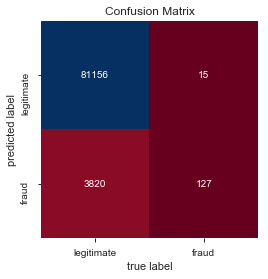

In [13]:
make_SMOTE_model(X_train_sc, y_train_sc, X_test_sc, y_test_sc, LogisticRegression(fit_intercept = False, C = 1e12, class_weight={0: 1, 1: 2}))

### Random Forest

A Random Forest model trained with an oversampled minority class produced the model with the best F1 score, so we fine-tuned and cross validated it using a grid search. 

In [15]:
smote = SMOTE(random_state=1)
classifier = RandomForestClassifier(class_weight={0: 1, 1: 2}, n_estimators=30, n_jobs=3)

pipe = Pipeline([('smote', smote), ('classifier', classifier)])

param_grid = {
    
#     'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [10, 12],
    'classifier__min_samples_split': [8, 10],
}

gs = GridSearchCV(pipe, param_grid, cv = 5, scoring='f1')
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('smote',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                                              random_state=1, ratio=None,
                                              sampling_strategy='auto',
                                              svm_estimator='deprecated')),
                                       ('classifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight={0: 1,
                                                                             1: 2},
                                                               crit...
                              

In [16]:
print("Best parameters:", gs.best_params_)
print("Best score:", gs.best_score_)

Best parameters: {'classifier__max_depth': 12, 'classifier__min_samples_split': 8}
Best score: 0.7480892316646307


In [17]:
test_predictions = gs.predict(X_test)
test_probabilities = gs.predict_proba(X_test)

Test Accuracy: 0.998836908761954
Test Precision: 0.6201117318435754
Test Recall: 0.7816901408450704
Test F1: 0.691588785046729


Confusion Matrix: 
TN: 84908 FP: 68 FN: 31 TP: 111


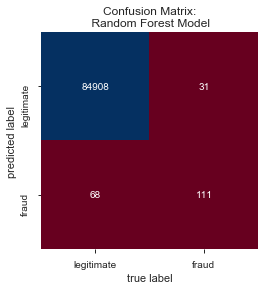

In [18]:
print('Test Accuracy: ' + str(metrics.accuracy_score(y_test, test_predictions)))
print('Test Precision: ' + str(metrics.precision_score(y_test, test_predictions)))
print('Test Recall: ' + str(metrics.recall_score(y_test, test_predictions)))
print('Test F1: ' + str(metrics.f1_score(y_test, test_predictions)))
print('\n')
    

# print confusion matrix    
cm = confusion_matrix(y_test, test_predictions)
sns.heatmap(cm.T, square=True, annot=True, fmt = 'g', cmap='RdBu', cbar=False, xticklabels=['legitimate', 'fraud'], yticklabels=['legitimate', 'fraud'])
plt.title('Confusion Matrix:\n Random Forest Model')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.savefig('cm_randomforest')

tn, fp, fn, tp = confusion_matrix(y_test, test_predictions).ravel()
print("Confusion Matrix:",'\nTN:', tn, 'FP:', fp, 'FN:', fn, 'TP:', tp)

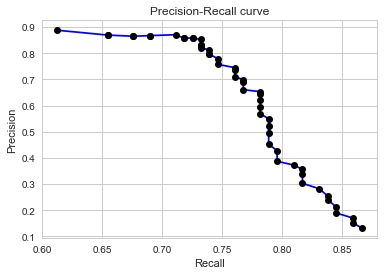

In [19]:
probs = pd.DataFrame(test_probabilities, columns=['prob_legit', 'prob_fraud'])
probs['actual']=[i for i in y_test]
probs.head()

# # print 
def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step

names = ['cut_off', 'recall', 'precision']
fraud_metrics = pd.DataFrame()

# for loop to test different cut-off values
for i in frange(.2,.95,.015):
    probs['label'] = np.where(probs['prob_fraud'] >= i, 1, 0)
    tn, fp, fn, tp = confusion_matrix(probs['actual'], probs['label']).ravel()
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    evals = [i,recall,precision]
    fraud_metrics=fraud_metrics.append(pd.Series(evals), ignore_index=True)

fraud_metrics.columns = names

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
# plot the data
plt.plot(fraud_metrics.recall, fraud_metrics.precision , '-', color='blue')
plt.plot(fraud_metrics.recall, fraud_metrics.precision , 'o', color='black')
# make some nice labels
plt.title('Precision-Recall curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.savefig('pr_curve')

In [20]:
# Inspecting the amounts of frauds that our model missed
pred_vs_actual = pd.DataFrame({"Amount": X_test['Amount'], "Predicted": test_predictions, "Actual": [i for i in y_test]})
pred_vs_actual.loc[(pred_vs_actual['Predicted']==0) & (pred_vs_actual['Actual']==1)]['Amount'].describe()

count    31.000000
mean      2.486742
std       4.268075
min      -0.305938
25%      -0.292032
50%       0.006536
75%       3.865526
max      14.949103
Name: Amount, dtype: float64